In [33]:
# do not autoreload - to prevent boxes IDs generator from reseting
#%reload_ext autoreload
#%autoreload 2
%matplotlib inline

In [34]:
from models import *
from utils import *

import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image
from IPython.display import clear_output
from sort import *

In [35]:
mpl.rcParams.update({'font.size': 14})
cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

In [36]:
DISPLAY = 1
DATA = Path(r'D:\Media\Videos\Ayalon')
# videopath = str(DATA/'20190622_124116.mp4') # bad detection
# videopath = str(DATA/'20190703_163050_slipping_protest.2.mp4') # fast
videopath = str(DATA/'20190612_175832.mp4') # slow

tracks_path = r'tracking_demo_data/20190612_175832.slow.pkl' # r'../slow.pkl'
car = '4076' # '2110' # '3576' # '3740' # '3967' # '79' # '494' # '1662'

# Set YOLO model and detection function

In [37]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [38]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

# Load tracked data

In [39]:
with open(tracks_path,'rb') as f:
    dct = pkl.load(f)
X = dct['X']
Y = dct['Y']
S = dct['S']
C = dct['C']
df = dct['df']

In [40]:
ids = np.where(X[car].notnull())[0]
pd.DataFrame({'X':X.loc[ids,car],'Y':Y.loc[ids,car],'S':S.loc[ids,car],'C':C.loc[ids,car]})

,X,Y,S,C
1232,434,166,68,car
1233,433.5,168,68.884,car
1234,440.5,167.5,69.3542,car
1235,444,166.5,70.2353,car


In [41]:
df.loc[car]

class                           car
n_shots                           4
consistent_class               True
consistent_xy_nas              True
continuous_track               True
avg_size                    69.1184
max_size                    70.2353
valid_size                     True
neg_x_motion              0.0454545
neg_y_motion               0.428571
valid_x_dir                   False
valid_y_dir                   False
min_x                         433.5
max_x                           444
min_y                           166
max_y                           168
t0                          328.533
dt                              0.8
dx                             10.5
dy                                2
x_path_rel                0.0161538
y_path_rel               0.00666667
long_path                     False
v                            13.361
abs_v                       4.23981
road_perpendicularity       28.9793
Name: 4076, dtype: object

In [42]:
def plot_track(X, Y, car, ax=None):
    if ax is None:
        ax = plt.gca()
    t0 = np.where(X[car].notnull())[0][0]
    ax.plot(X.loc[t0,car], Y.loc[t0,car], 's', color=colors[int(car) % len(colors)])
    ax.plot(X.loc[:,car],  Y.loc[:,car], '.-', color=colors[int(car) % len(colors)], label=car)

def set_track_figure(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_xlim((img.shape[1],0))
    ax.set_ylim((img.shape[0],0))
    ax.grid()

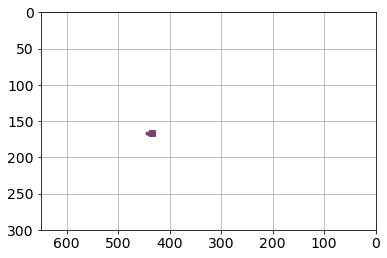

In [43]:
set_track_figure()
plot_track(X,Y,car)

# Apply debug tracking

In [44]:
def decode_xy(x,y):
    return (int(((x - pad_x // 2) / unpad_w) * img.shape[1]),
            int(((y - pad_y // 2) / unpad_h) * img.shape[0]) )

#(pilimg.size, img.shape, img_size, (pad_y, pad_x), (unpad_h, unpad_w))

#### Continuous

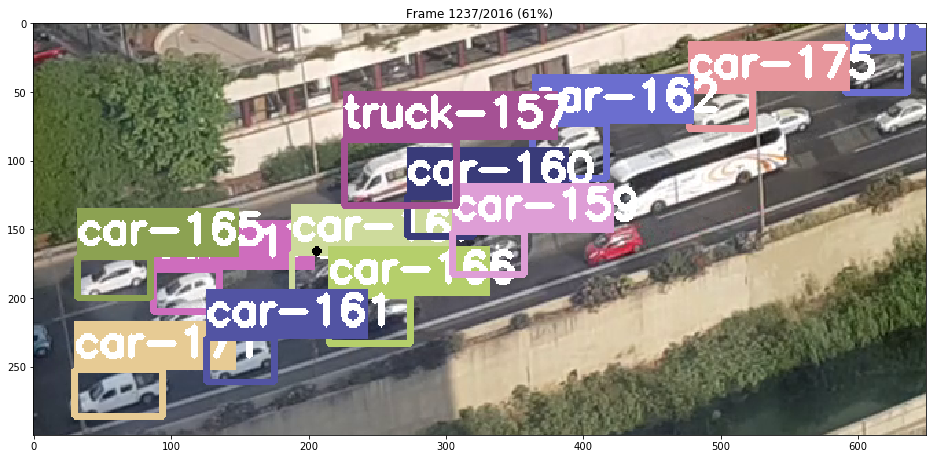

In [45]:
%pylab inline

# initialize Sort object and video capture
vid = cv2.VideoCapture(videopath)
n_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
mot_tracker = Sort()

for ii in range(ids[0]-3):
    ret, frame = vid.read()

for ii in range(ids[0]-3, n_frames):
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)[-350:-50,:650,:] # [-450:-50,:950,:]
    pilimg = Image.fromarray(frame)
    detections = detect_image(pilimg)

    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    if detections is not None:
        tracked_objects = mot_tracker.update(detections.cpu())

        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
            box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
            box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
            y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
            x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])

            color = colors[int(obj_id) % len(colors)]
            color = [i * 255 for i in color]
            cls = classes[int(cls_pred)]
            cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
            cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
            cv2.putText(frame, cls + "-" + str(int(obj_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)

    for i in [ii-1,ii,ii+1]:
        if i in ids:
            cv2.rectangle(frame, (int(img.shape[1]-(X.loc[i,car]-1)), int(Y.loc[i,car]-1)),
                          (int(img.shape[1]-(X.loc[i,car]+1)), int(Y.loc[i,car]+1)), (0,0,0), 4)

    fig=figure(figsize=(16, 8))
    title(f"Frame {ii+1:d}/{n_frames:d} ({100*(ii)/n_frames:.0f}%)")
    imshow(frame)
    show()
    clear_output(wait=True)

    if np.all([i<ii for i in ids]):
        break

In [31]:
(mot_tracker.trackers[0].kf)

KalmanFilter object
dim_x = 7
dim_z = 4
dim_u = 0
x = [[ 84.28308696 218.73488272 700.57688011   1.68040311 -11.63834282    3.42671245   9.79768549]].T
P = [[0.654397   0.         0.         0.         0.06119262 0.
      0.        ]
     [0.         0.654397   0.         0.         0.         0.06119262
      0.        ]
     [0.         0.         3.14232092 0.         0.         0.
      0.16375088]
     [0.         0.         0.         2.70156539 0.         0.
      0.        ]
     [0.06119262 0.         0.         0.         0.1145133  0.
      0.        ]
     [0.         0.06119262 0.         0.         0.         0.1145133
      0.        ]
     [0.         0.         0.16375088 0.         0.         0.
      0.06105043]]
x_prior = [[ 89.06513975 217.55457764 719.26630984   1.66747574 -11.19117335    3.31634219  10.77161866]].T
P_prior = [[1.89349339 0.         0.         0.         0.17706045 0.
            0.        ]
           [0.         1.89349339 0.         0.         

#### Frame by frame debug

In [108]:
# initialize Sort object and video capture
vid = cv2.VideoCapture(videopath)
n_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
mot_tracker = Sort() 

ii = ids[0]-3

for _ in range(ii):
    ret, frame = vid.read()

In [120]:
%pylab inline

ii += 1
print(ii)

ret, frame = vid.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)[-350:-50,:650,:] # [-450:-50,:950,:]
pilimg = Image.fromarray(frame)
detections = detect_image(pilimg)

img = np.array(pilimg)
pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x
if detections is not None:
    #import ipdb; ipdb.set_trace()
    tracked_objects = mot_tracker.update(detections.cpu())

    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
        box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
        box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
        y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
        x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])

        color = colors[int(obj_id) % len(colors)]
        color = [i * 255 for i in color]
        cls = classes[int(cls_pred)]
        cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
        cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
        cv2.putText(frame, cls + "-" + str(int(obj_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)

    # extra dots plots
    for t in mot_tracker.trackers:
        xy = decode_xy(*t.kf.x.transpose()[0][0:2])
        color = colors[int(t.id+1) % len(colors)]
        color = [i * 255 for i in color]
        cv2.rectangle(frame, (int(xy[0]-1), int(xy[1]-1)), (int(xy[0]+1), int(xy[1]+1)), color, 4)

    for i in [ii-1,ii,ii+1]:
        if i in ids:
            cv2.rectangle(frame, (int(img.shape[1]-(X.loc[i,car]-1)), int(Y.loc[i,car]-1)),
                          (int(img.shape[1]-(X.loc[i,car]+1)), int(Y.loc[i,car]+1)), (0,0,0), 4)

Populating the interactive namespace from numpy and matplotlib
229


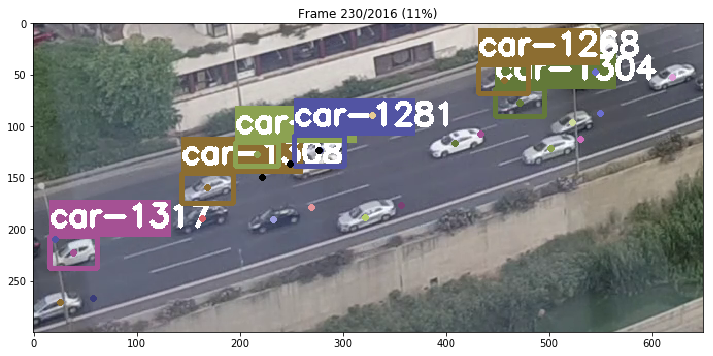

In [121]:
fig=figure(figsize=(12, 8))
title(f"Frame {ii+1:d}/{n_frames:d} ({100*(ii)/n_frames:.0f}%)")
imshow(frame)
show()
#clear_output(wait=True)

In [41]:
for t in mot_tracker.trackers:
    print([t.id+1,t.kf.x.transpose(),t.time_since_update])#,t.history])

[194, array([[160.98791504, 243.77781677, 659.28540039,   1.6607182 ,
          0.        ,   0.        ,   0.        ]]), 1]
[195, array([[198.92601013, 205.72290039, 591.33703613,   1.76532567,
          0.        ,   0.        ,   0.        ]]), 1]
[196, array([[273.73379517, 195.55802917, 511.96499634,   1.66663241,
          0.        ,   0.        ,   0.        ]]), 1]
[197, array([[190.5973053 , 189.21356201, 566.55773926,   1.66576207,
          0.        ,   0.        ,   0.        ]]), 1]
[198, array([[ 82.92003632, 251.89862061, 880.18310547,   1.60315096,
          0.        ,   0.        ,   0.        ]]), 1]
[199, array([[  28.4489356 ,  254.39169112,  695.38164287,    1.97180659,
         -14.35370337,    3.37686817, -167.59257464]]), 0]
[200, array([[358.4274292 , 157.79049683, 524.62689209,   1.75917649,
          0.        ,   0.        ,   0.        ]]), 1]
[201, array([[332.68670654, 190.88156128, 582.60595703,   1.92860413,
          0.        ,   0.        ,   0. 